# Short straddle

Short straddle for intraday

In [1]:
import pandas as pd
import numpy as np
import py_vollib.black_scholes as bs
from typing import Tuple

In [2]:
# parameters
spot:float = 17000
risk_free_rate:float = 0.1
sigma = 0.2
de = 1 #days to expiry


In [3]:
# We set the spot equal to strike
kwargs = {
    'flag': 'c',
    'S': spot,
    'K': spot,
    't': 1,
    'r': risk_free_rate,
    'sigma': sigma
}

<AxesSubplot:xlabel='spot'>

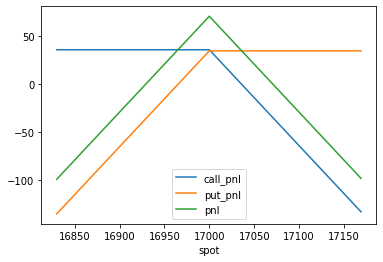

In [4]:
rng = range(int(spot*0.99), int(spot*1.01))

collect = []
for i in rng:
    kwargs.update({'t': de*24/(24*365), 'flag': 'c', 'S':i})
    call_price = bs.black_scholes(**kwargs)
    kwargs.update({'t': de*24/(24*365), 'flag': 'p', 'S':i})
    put_price = bs.black_scholes(**kwargs)
    collect.append((i,call_price,put_price))

prices = pd.DataFrame(collect, columns=['spot', 'call_end', 'put_end'])
kwargs.update({'t':(de*24+6)/(24*365), 'flag': 'c', 'S':spot})
prices['call_start'] = bs.black_scholes(**kwargs)
kwargs.update({'t':(de*24+6)/(24*365), 'flag': 'p', 'S':spot})
prices['put_start'] = bs.black_scholes(**kwargs)
prices['call_pnl'] = prices.eval('call_start-call_end')
prices['put_pnl'] = prices.eval('put_start-put_end')
prices['pnl'] = prices.eval('call_pnl+put_pnl')
cols = ['call_pnl', 'put_pnl', 'pnl']
prices.set_index('spot')[cols].plot()

## The sweet spot for a straddle

<AxesSubplot:xlabel='spot'>

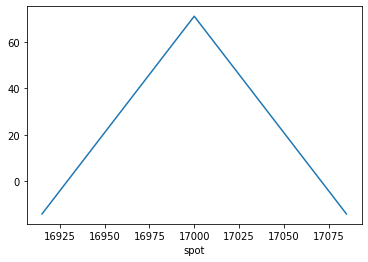

In [5]:
prices.set_index('spot').loc[spot*0.995:spot*1.005].pnl.plot()

## Delta

Let's see how delta behaves with change in spot price

count    143.000000
mean       0.858349
std        0.001348
min        0.856026
25%        0.857195
50%        0.858355
75%        0.859505
max        0.860646
Name: delta, dtype: float64

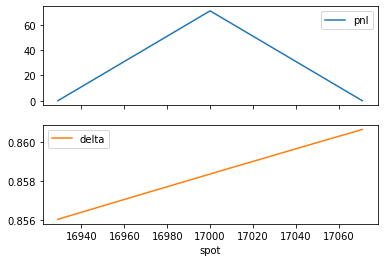

In [7]:
import py_vollib.black_scholes.greeks.analytical as greeks
rng = range(int(spot*0.99), int(spot*1.01))

collect = []
for i in rng:
    kwargs.update({'t': 6+(de*24)/(24*365), 'flag': 'c', 'S':i})
    call_delta = greeks.delta(**kwargs)
    kwargs.update({'t': 6+(de*24)/(24*365), 'flag': 'p', 'S':i})
    put_price = bs.black_scholes(**kwargs)
    put_delta = greeks.delta(**kwargs)
    collect.append((i,call_delta,put_delta))

deltas = pd.DataFrame(collect, columns=['spot', 'call_delta', 'put_delta'])
deltas['delta'] = deltas.eval('call_delta+put_delta')
deltas = deltas.merge(prices[['spot', 'pnl']], on=['spot'])
cols = ['pnl', 'delta']
deltas.query('pnl>0').set_index('spot')[cols].plot(subplots=True)
deltas.query('pnl>0').delta.describe()